# IMport data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sid321axn/beijing-multisite-airquality-data-set")

print("Path to dataset files:", path)

c:\Users\marte\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\marte\.cache\kagglehub\datasets\sid321axn\beijing-multisite-airquality-data-set\versions\1


# Imports

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Exploratory Data analysis

hello world


(array([8.012e+03, 4.883e+03, 3.821e+03, 3.342e+03, 2.869e+03, 2.244e+03,
        1.800e+03, 1.395e+03, 1.136e+03, 8.960e+02, 7.100e+02, 5.280e+02,
        4.700e+02, 4.310e+02, 3.410e+02, 2.540e+02, 1.920e+02, 1.960e+02,
        1.220e+02, 1.000e+02, 6.200e+01, 5.200e+01, 5.000e+01, 4.300e+01,
        2.900e+01, 3.500e+01, 2.900e+01, 2.500e+01, 1.400e+01, 1.100e+01,
        1.100e+01, 4.000e+00, 9.000e+00, 4.000e+00, 6.000e+00, 4.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  3. ,  20.9,  38.8,  56.7,  74.6,  92.5, 110.4, 128.3, 146.2,
        164.1, 182. , 199.9, 217.8, 235.7, 253.6, 271.5, 289.4, 307.3,
        325.2, 343.1, 361. , 378.9, 396.8, 414.7, 432.6, 450.5, 468.4,
        486.3, 504.2, 522.1, 540. , 557.9, 575.8, 593.7, 611.6, 629.5,
        647.4, 665.3, 683.2, 701.1, 719. , 736.9, 754.8, 772.7, 790.6,
        808.5, 826.4,

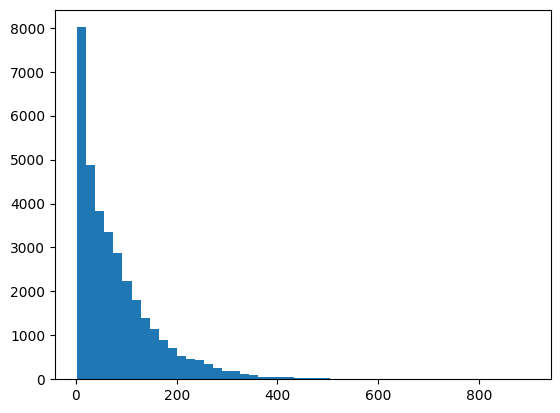

In [4]:
print("hello world")

df = pd.read_csv(os.path.join(path, "PRSA_Data_Aotizhongxin_20130301-20170228.csv"))
airpoll = df['PM2.5']
airpoll.describe()

# boxplot of PM2.5 levels
plt.hist(airpoll.dropna(), bins=50)